### Exploration notebook 1 - clustering project

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
from sklearn.cluster import KMeans


from wrangle_zillow import acquire_zillow
from wrangle_zillow import missing_col_values
from wrangle_zillow import missing_row_values
from wrangle_zillow import single_unit_properties
from wrangle_zillow import data_prep
from wrangle_zillow import split_data
from wrangle_zillow import remove_outliers
from wrangle_zillow import split_by_region

In [2]:
df = acquire_zillow()
df.head()

Reading from csv file...


,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
0,1727539,14297519,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,...,6.059063e+13,0.025595,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
1,1387261,17052889,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,...,6.111001e+13,0.055619,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
2,11677,14186244,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,...,6.059022e+13,0.005383,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
3,2288172,12177905,NaN,NaN,NaN,3.0,4.0,NaN,8.0,3.0,...,6.037300e+13,-0.103410,2017-01-01,NaN,NaN,NaN,Central,Single Family Residential,NaN,NaN
4,1970746,10887214,1.0,NaN,NaN,3.0,3.0,NaN,8.0,3.0,...,6.037124e+13,0.006940,2017-01-01,Central,NaN,NaN,Central,Condominium,NaN,NaN


In [3]:
df.shape

(77381, 68)

In [4]:
df = single_unit_properties(df)
remove_cols = ['buildingqualitytypeid', 'heatingorsystemtypeid', 'propertyzoningdesc', 'heatingorsystemdesc']
df = data_prep(df, cols_to_remove=remove_cols, prop_required_column=.5, prop_required_row=.75)


In [5]:
df.shape

(50973, 30)

In [6]:
train, validate, test = split_data(df)
train.shape, validate.shape, test.shape

((28544, 30), (12234, 30), (10195, 30))

In [7]:
out_columns = ['bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet',]
train = remove_outliers(train, 1.5, out_columns)

In [8]:
train.shape

(26097, 30)

-----

In [9]:
train.columns

Index(['id', 'parcelid', 'bathroomcnt', 'bedroomcnt', 'calculatedbathnbr',
       'calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'fips',
       'fullbathcnt', 'latitude', 'longitude', 'lotsizesquarefeet',
       'propertycountylandusecode', 'propertylandusetypeid',
       'rawcensustractandblock', 'regionidcity', 'regionidcounty',
       'regionidzip', 'roomcnt', 'unitcnt', 'yearbuilt',
       'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'assessmentyear',
       'landtaxvaluedollarcnt', 'taxamount', 'censustractandblock', 'logerror',
       'transactiondate', 'propertylandusedesc'],
      dtype='object')

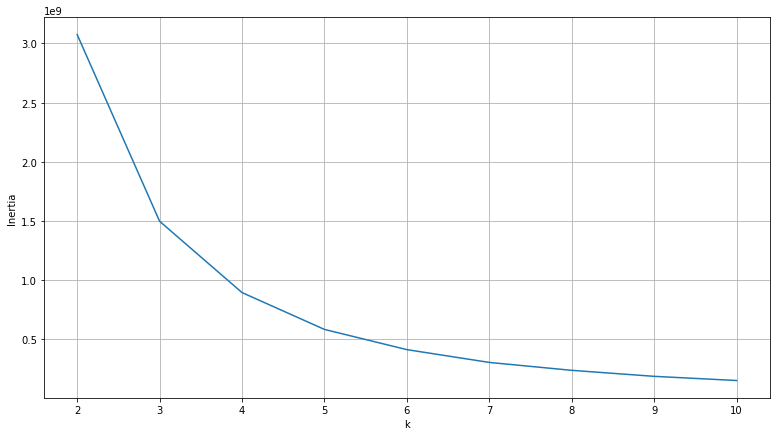

In [12]:
cols = ['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet']
x = train[cols]

inertias = {}

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(x)
    inertias[k] = kmeans.inertia_

pd.Series(inertias).plot(xlabel='k', ylabel='Inertia', figsize=(13, 7))
plt.grid()

In [13]:
x = train[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet']]
kmeans = KMeans(n_clusters=4)
kmeans.fit(x)
train['cluster'] = kmeans.predict(x)

In [14]:
train.head()

,id,parcelid,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,latitude,...,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transactiondate,propertylandusedesc,cluster
57956,2335449,12844928,3.0,4.0,3.0,2650.0,2650.0,6037.0,3.0,33982542.0,...,413700.0,793000.0,2016.0,379300.0,9646.34,6.037409e+13,0.026122,2017-05-26,Single Family Residential,3
73971,244642,12075460,3.0,3.0,3.0,3094.0,3094.0,6037.0,3.0,34187250.0,...,133565.0,231922.0,2016.0,98357.0,3221.28,6.037461e+13,-0.030712,2017-05-31,Single Family Residential,3
8195,877004,14282224,2.0,3.0,2.0,1647.0,1647.0,6059.0,2.0,33639152.0,...,79671.0,1092488.0,2016.0,1012817.0,12046.64,6.059063e+13,-0.013707,2017-08-07,Single Family Residential,2
7355,2249559,14393950,1.5,3.0,1.5,1174.0,1174.0,6059.0,1.0,33572200.0,...,93580.0,366000.0,2016.0,272420.0,3744.58,6.059042e+13,0.028213,2017-05-24,Single Family Residential,1
58226,1156183,12514614,3.0,3.0,3.0,1742.0,1742.0,6037.0,3.0,33794806.0,...,164991.0,525213.0,2016.0,360222.0,6283.46,6.037574e+13,-0.002124,2017-06-22,Single Family Residential,2


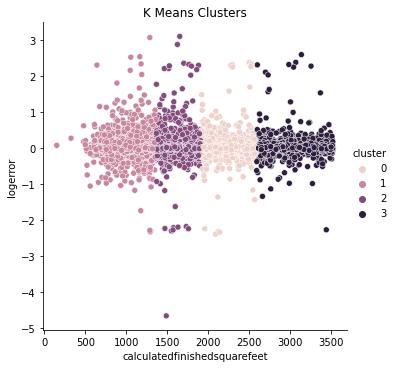

In [16]:
sns.relplot(data=train, y='logerror', x='calculatedfinishedsquarefeet', hue='cluster')
plt.title('K Means Clusters')
plt.show()

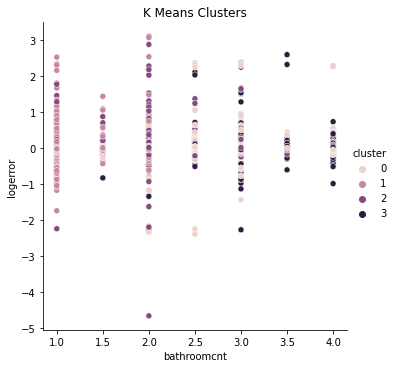

In [17]:
sns.relplot(data=train, y='logerror', x='bathroomcnt', hue='cluster')
plt.title('K Means Clusters')
plt.show()

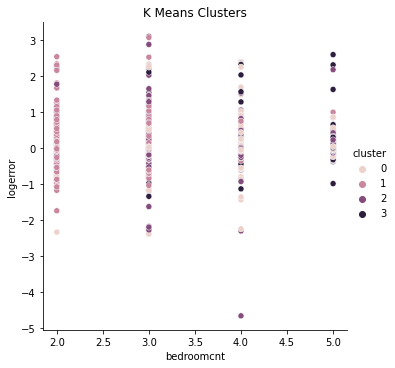

In [18]:
sns.relplot(data=train, y='logerror', x='bedroomcnt', hue='cluster')
plt.title('K Means Clusters')
plt.show()

In [19]:
train.logerror.mean()

0.014703848264029875

In [20]:
#log error by cluster?

---

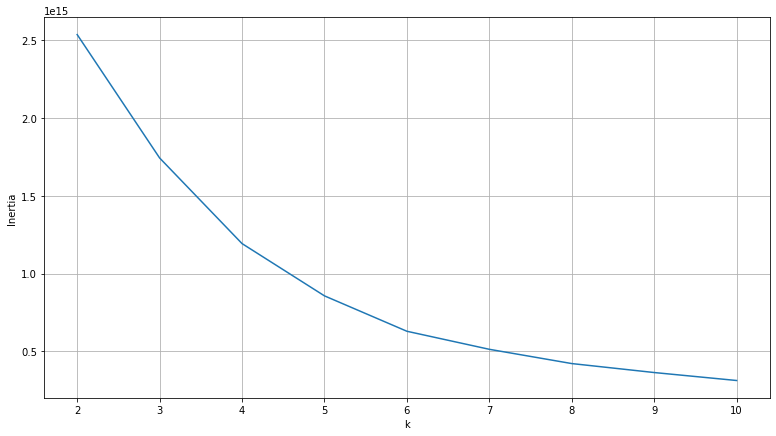

In [9]:
cols = ['latitude', 'longitude']
x = train[cols]

inertias = {}

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(x)
    inertias[k] = kmeans.inertia_

pd.Series(inertias).plot(xlabel='k', ylabel='Inertia', figsize=(13, 7))
plt.grid()

In [10]:
x = train[['latitude', 'longitude']]
kmeans = KMeans(n_clusters=5)
kmeans.fit(x)
train['cluster'] = kmeans.predict(x)

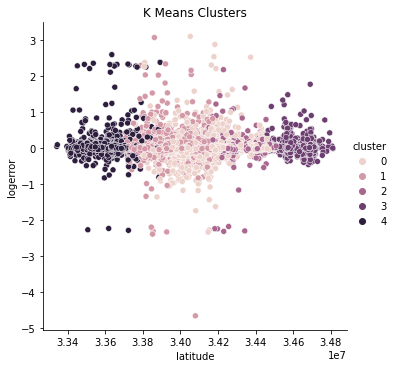

In [11]:
sns.relplot(data=train, y='logerror', x='latitude', hue='cluster')
plt.title('K Means Clusters')
plt.show()

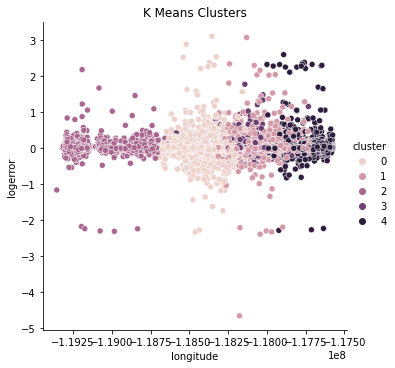

In [12]:
sns.relplot(data=train, y='logerror', x='longitude', hue='cluster')
plt.title('K Means Clusters')
plt.show()

---

In [9]:
x = train[['latitude', 'longitude']]
kmeans = KMeans(n_clusters=4)
kmeans.fit(x)
train['cluster'] = kmeans.predict(x)

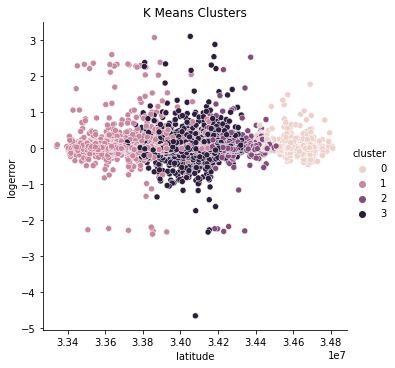

In [10]:
sns.relplot(data=train, y='logerror', x='latitude', hue='cluster')
plt.title('K Means Clusters')
plt.show()

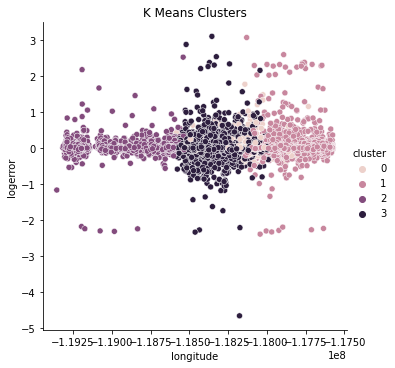

In [11]:
sns.relplot(data=train, y='logerror', x='longitude', hue='cluster')
plt.title('K Means Clusters')
plt.show()

In [12]:
## mean log error by lat/long clusters

---

In [13]:
train.longitude.value_counts()

-117817000.0    4
-117830000.0    4
-117847000.0    4
-117874000.0    3
-117692228.0    3
               ..
-118442865.0    1
-118020936.0    1
-118129364.0    1
-118237972.0    1
-117593269.0    1
Name: longitude, Length: 25700, dtype: int64

fips code 6037.0 = los angeles county 
    - major beach = santa monica beach - 34.012355 / -118.498665

fips code 6059.0 = Orange county
    - major beach = huntington beach - 33.640954 / -117.978893
    
fips code 6111.0 = ventura county
    - major beach = san buenaventura beach - 34.267111 / -119.278788